In [56]:
import json
import torch
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)


In [19]:
unique_intents = list(set(train_labels)) 
unique_intents[:5]

['damaged_card', 'min_payment', 'w2', 'definition', 'redeem_rewards']

In [4]:
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]

# Check the number of samples in each subset
len(train_sentences), len(val_sentences), len(test_sentences), len(oos_train_sentences), len(oos_val_sentences), len(oos_test_sentences)


(15000, 3000, 4500, 100, 100, 1000)

In [40]:
from sentence_transformers import SentenceTransformer, models

In [41]:
word_embedding_model = models.Transformer('distilroberta-base')

In [51]:
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode="max")

In [52]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [59]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [60]:
train_embeddings = model.encode(train_sentences)
val_embeddings = model.encode(val_sentences)
test_embeddings = model.encode(test_sentences)
oos_train_embeddings = model.encode(oos_train_sentences)
oos_val_embeddings = model.encode(oos_val_sentences)
oos_test_embeddings = model.encode(oos_test_sentences)

In [61]:
train_embeddings.shape

(15000, 768)

In [62]:
import numpy as np
from scipy.linalg import inv

In [63]:
intent_means = {}

for intent in unique_intents:
    indices = [i for i, label in enumerate(train_labels) if label == intent]
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    intent_means[intent] = intent_mean

In [64]:
len(intent_means)

150

In [65]:
intent_means["damaged_card"].shape

(768,)

In [71]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

In [72]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

In [73]:
from scipy.spatial import distance

In [74]:
# Function to get the minimum Mahalanobis distance to any intent for a given sample
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)


In [75]:
from sklearn.metrics import average_precision_score

# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.5208981771196598

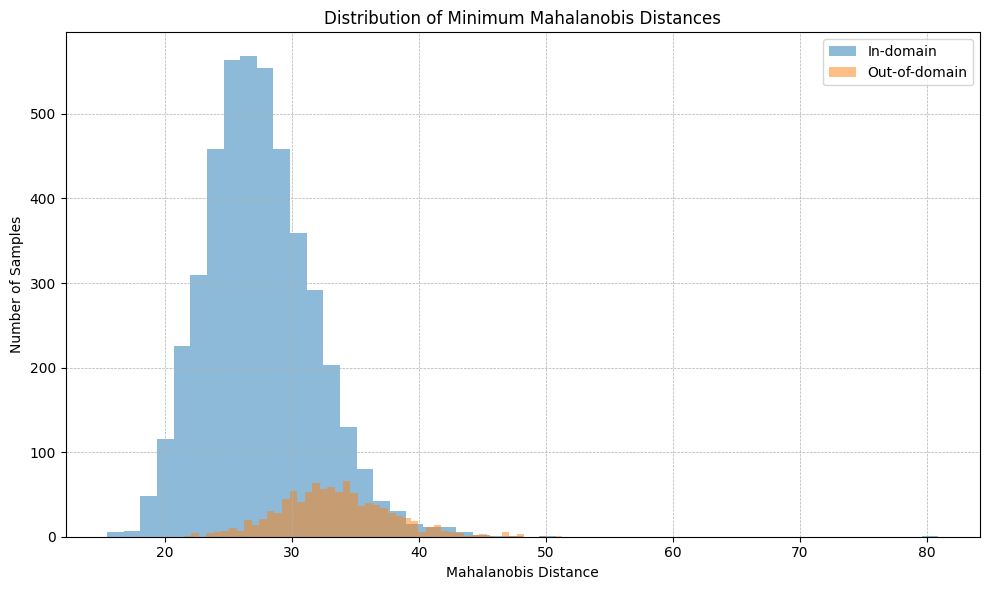

In [80]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


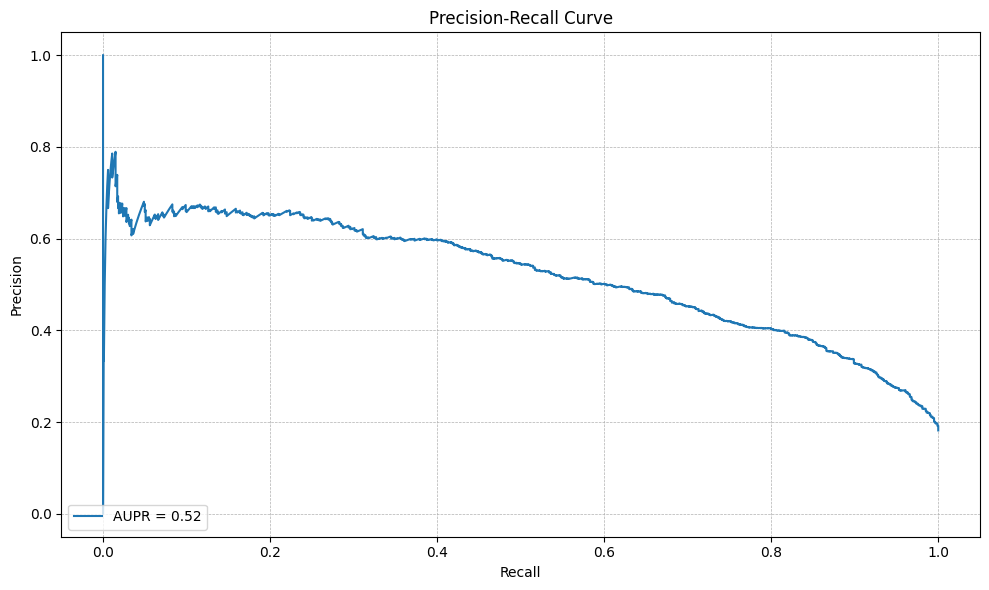

In [81]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate the area under the precision-recall curve
aupr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPR = {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [82]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Find the FPR where the TPR is closest to 0.95
idx = np.where(tpr >= 0.95)[0][0]
fpr_95 = fpr[idx]

fpr_95

0.5564444444444444